# **$STW-$ $7089CME$: Modeling Power Plant Energy Output Using Nonlinear Regression:**

In [1]:
# Install and import packages: 

# Define all required packages: 
pkg_groups <- list(
  data_tools = list(
    packages = c("readr", "dplyr", "tidyr", "purrr", "reshape2", "zoo"),
    purpose = "Data I/O and manipulation"
    # readr: Fast CSV/TSV file reading and parsing  
    # dplyr: Core data manipulation (filter, mutate, summarize)  
    # tidyr: Data tidying (pivoting, nesting, handling missing values)  
    # purrr: Functional programming tools (map, reduce, list operations)  
    # reshape2: Convert data between wide/long formats (melt/dcast)  
    # zoo: Time-series operations (rolling windows, lag calculations) 
), 

  visualization = list(
    packages = c("ggplot2", "GGally", "viridis", "patchwork", "gridExtra", "corrplot"),
    purpose = "Data visualization"
    # ggplot2: Create elegant and customizable data visualizations  
    # GGally: Extended ggplot2 functionality (scatterplot matrices, etc.)  
    # viridis: Colorblind-friendly color scales for plots  
    # patchwork: Combine and arrange multiple ggplot2 plots  
    # gridExtra: Layout arrangements for grid-based graphics  
    # corrplot: Visualize correlation matrices with color coding 
), 

  stats = list(
    packages = c("car", "nortest", "moments", "MASS", "outliers"),
    purpose = "Statistical analysis"
    # car: Regression diagnostics and hypothesis testing  
    # nortest: Normality tests (Anderson-Darling, Shapiro-Wilk etc.)  
    # moments: Skewness, kurtosis and related moment calculations  
    # MASS: Modern applied statistics functions and datasets  
    # outliers: Detect and handle statistical outliers 
  ),

  utilities = list(
    packages = c("stringr", "knitr"),
    purpose = "Utility functions"
    # stringr: Consistent string manipulation and pattern matching  
    #knitr: Dynamic report generation and reproducible research  
  )
)

# install if not installed already and then load them: 
suppressPackageStartupMessages({
  suppressWarnings({
    for (group in pkg_groups) {
      message("[Loading] ", group$purpose, " packages...")
      for (pkg in group$packages) {
        if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
          install.packages(pkg, quiet = TRUE, repos = "https://cloud.r-project.org")
          library(pkg, character.only = TRUE, quietly = TRUE)
        }
      }
    }
  })
})

# Verify that the packages are loaded successfully 
loaded <- search()
message("All packages loaded successfully!")

[Loading] Data I/O and manipulation packages...

[Loading] Data visualization packages...

[Loading] Statistical analysis packages...

[Loading] Utility functions packages...

All packages loaded successfully!



In [2]:
# Setting default values like themes, colors, fonts and size etc for each plot:

# Set default plot size using repr
# width and height are in inches
options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width = 20,   # Set default plot width
        repr.plot.height = 8)  # Set default plot height

# Define a custom ggplot2 theme for all plots:
my_custom_theme <- theme_minimal(base_size = 12) +   # Base theme with larger font
                   theme(
                     plot.title = element_text(face = "bold", hjust = 0.5),
                     axis.title = element_text(face = "bold"),
                     legend.position = "bottom"
                   )

# Set this theme as default for all plots
theme_set(my_custom_theme)

# Set default color scale or palette
scale_fill_continuous <- scale_fill_viridis_c   # use Viridis for continuous fill
scale_color_discrete <- scale_color_brewer(palette = "Set2")  # For discrete color scale

Import dataset using `read_csv` from `readr` package:

In [3]:
# Read the dataset using readr package:
data <- read_csv('dataset.csv', show_col_types = FALSE)

In [4]:
# Check the shape: rows and columns of the dataset:
nrow(data) 
ncol(data)

[1] 9568

[1] 5

Now, clean the dataset by deleting duplicated samples:

In [5]:
# create a variable which contains only duplicated rows and their first occurrence:
duplicates_only <- duplicated(data)

# Drop only those duplicated rows
data <- data[!duplicates_only, ]

In [6]:
# Add time column at the beginning of the dataset which acts as the time stamps
# The data assumbed to be recorded at an equal time interval of 1 units
data$time <- 1:nrow(data)


# Reorder the columns
data <- data[, c("time", "x1", "x3", "x4", "x5", "x2")] 
# x2 is the dependent variable (sometimes denoted as y) 
#and move x2 to the end of the dataset as per the general convention in machine learning 

All set.

## **Task-2: Regression- Modelling the Relationship Between Environmental Variables and Power Output:**

First, prepare the data for modeling:

In [7]:
# Create a clean dataset for modeling with original variable names
# This makes it easier to match the model formulas
data <- data.frame(
  x1 = data$x1,   # Temperature
  x3 = data$x3,   # Ambient Pressure
  x4 = data$x4,   # Exhaust Vacuum
  x5 = data$x5,   # Relative Humidity
  y = data$x2    # Output variable (Energy Output)
)

In [8]:
# Max-Abs Scaling

# Formula: x_scaled = x / max(abs(x))

data <- data.frame(
  x1 = data$x1 / max(abs(data$x1)),
  x3 = data$x3 / max(abs(data$x3)),
  x4 = data$x4 / max(abs(data$x4)),
  x5 = data$x5 / max(abs(data$x5)),
  #y  = data$y  / max(abs(data$y))
  y= data$y
)
head(data)

,x1,x3,x4,x5,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2247373,0.4998774,0.9782638,0.8986621,480.48
2,0.6370251,0.7171408,0.9788058,0.7408147,445.75
3,0.8014012,0.6976459,0.9746927,0.4184305,438.76
4,0.5138777,0.6092447,0.9747605,0.7666733,453.09
5,0.3179736,0.4985287,0.9843511,0.9704473,464.43
6,0.3764484,0.4801373,0.9833059,0.8446486,470.96


In [9]:
# Check summary statistics of transformed data: 
summary(data[, c("x1", "x3", "x4", "x5")])

       x1                x3               x4               x5        
 Min.   :0.04877   Min.   :0.3109   Min.   :0.9609   Min.   :0.2552  
 1st Qu.:0.36459   1st Qu.:0.5118   1st Qu.:0.9766   1st Qu.:0.6327  
 Median :0.54837   Median :0.6385   Median :0.9803   Median :0.7488  
 Mean   :0.52973   Mean   :0.6657   Mean   :0.9806   Mean   :0.7322  
 3rd Qu.:0.69281   3rd Qu.:0.8155   3rd Qu.:0.9844   3rd Qu.:0.8471  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  

In [10]:
# Check standard deviation of transformed data:
sapply(data[, c("x1", "x3", "x4", "x5")], sd)

x1          x3          x4          x5 
0.200603532 0.155545721 0.005749082 0.145841786

**Following are the 5 model that we have to estimate the parameters for:**

**Model 1:**
> $y = \theta_1 x_4 + \theta_2 x_3^2 + \theta_{bias}$

This model relates `energy output` $y$ to exhaust vaccum (x4) and the square of ambient pressure (x3²), plus a bias term.

**Model 2:**
> $y = \theta_1 x_4 + \theta_2 x_3^2 + \theta_3 x_5 + \theta_{bias}$

This model extends Model 1 by adding relative humidity (x5) as an additional predictor.

**Model 3:**
> $y = \theta_1 x_3 + \theta_2 x_4 + \theta_3 x_5^3$

This model relates energy output to ambient pressure (x3), exhaust vaccum (x4), and the cube of relative humidity (x5³). Note that this model has no bias term.

**Model 4:**
> $y = \theta_1 x_4 + \theta_2 x_3^2 + \theta_3 x_5^3 + \theta_{bias}$

This model combines exhaust vaccum (x4), squared ambient pressure (x3²), and cubed relative humidity (x5³), plus a bias term.

**Model 5:**
> $y = \theta_1 x_4 + \theta_2 x_1^2 + \theta_3 x_3^2 + \theta_{bias}$

This model relates energy output to exhaust vaccum (x4), squared temperature (x1²), and squared ambient pressure (x3²), plus a bias term.

#### **Design Matrix:**

In R, these models can be implemented as follows:

In [11]:
# Create Design Matrix for Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4) 
# and the square of ambient pressure (x3²)
# 
#' @param data A dataframe containing the variables x3 and x4
#' @return A matrix with columns for bias term, x4, and squared x3
create_model_1_matrix <- function(data) {
  # Add column of 1's for the bias/intercept term
  # Add column for relative humidity (x4) as is
  # Add column for squared ambient pressure (x3^2)
  X <- cbind(1, data$x4, data$x3^2)
  
  # Assign meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x3_squared")
  
  # Return the complete design matrix
  return(X)
}
# Generate the design matrix using our dataset
model_1_matrix <- create_model_1_matrix(data)

# Display the first few rows of the design matrix
head(model_1_matrix)

bias,x4,x3_squared
1,0.9782638,0.2498774
1,0.9788058,0.5142909
1,0.9746927,0.4867098
1,0.9747605,0.3711791
1,0.9843511,0.2485309
1,0.9833059,0.2305318


In [12]:
# Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
# This model extends Model 1 by adding relative humidity (x5)

create_model_2_matrix <- function(data) {
  # Create design matrix for Model 2
  X <- cbind(1, data$x4, data$x3^2, data$x5)
  # Assign meaningful column names to the design matrix:
  colnames(X) <- c("bias", "x4", "x3_squared", "x5")
  return(X)
}

# Generate the design matrix using our dataset
model_2_matrix <-create_model_2_matrix(data)

# Display the first few rows of the design matrix
head(model_2_matrix)

bias,x4,x3_squared,x5
1,0.9782638,0.2498774,0.8986621
1,0.9788058,0.5142909,0.7408147
1,0.9746927,0.4867098,0.4184305
1,0.9747605,0.3711791,0.7666733
1,0.9843511,0.2485309,0.9704473
1,0.9833059,0.2305318,0.8446486


In [13]:
# Model 3: y = θ₁x₃ + θ₂x₄ + θ₃x₅³
# This model relates energy output to ambient pressure (x3), 
# exhaust vaccum (x4), 
# and the cube of relative humidity (x5³). 
#Note: No bias term in this model.

create_model_3_matrix <- function(data) {
  # Create design matrix for Model 3
  X <- cbind(data$x3, data$x4, data$x5^3)
  # Assign meaningful column names to the design matrix
  colnames(X) <- c("x3", "x4", "x5_cubed")
  return(X)
}
# Generate the design matrix using our dataset
model_3_matrix <- create_model_3_matrix(data)

# Display the first few rows of the design matrix
head(model_3_matrix)

x3,x4,x5_cubed
0.4998774,0.9782638,0.72575383
0.7171408,0.9788058,0.40656386
0.6976459,0.9746927,0.07326053
0.6092447,0.9747605,0.45064137
0.4985287,0.9843511,0.91393613
0.4801373,0.9833059,0.60259863


In [14]:
# Model 4: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
# This model combines exhaust vaccum (x4), 
#squared ambient pressure (x3²),
# and cubed relative humidity(x5³)

create_model_4_matrix <- function(data) {
  # Create design matrix for Model 4
  X <- cbind(1, data$x4, data$x3^2, data$x5^3)
  # Assigning meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x3_squared", "x5_cubed")
  return(X)
}

# Generate the design matrix using our dataset
model_4_matrix <- create_model_4_matrix(data)

# Display the first few rows of the design matrix
head(model_4_matrix)

bias,x4,x3_squared,x5_cubed
1,0.9782638,0.2498774,0.72575383
1,0.9788058,0.5142909,0.40656386
1,0.9746927,0.4867098,0.07326053
1,0.9747605,0.3711791,0.45064137
1,0.9843511,0.2485309,0.91393613
1,0.9833059,0.2305318,0.60259863


In [15]:
# Model 5: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4),
#squared temperature (x1²),
# and squared ambient pressure (x3²)

create_model_5_matrix <- function(data) {
  # Create design matrix for Model 5
  X <- cbind(1, data$x4, data$x1^2, data$x3^2)
  # Assigning meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x1_squared", "x3_squared")
  return(X)
}

# Generate the design matrix using our dataset
model_5_matrix <- create_model_5_matrix(data)

# Display the first few rows of the design matrix
head(model_5_matrix)

bias,x4,x1_squared,x3_squared
1,0.9782638,0.05050684,0.2498774
1,0.9788058,0.40580093,0.5142909
1,0.9746927,0.64224395,0.4867098
1,0.9747605,0.26407025,0.3711791
1,0.9843511,0.10110721,0.2485309
1,0.9833059,0.14171340,0.2305318


### **Task 2.1: Estimate Model Parameters:**

Here I define a function `estimate_parameters()` that implements the Least Squares formula. 

The mathematical expression for the Least Squares estimation is:

>  $θ̂ = (X^T X)^(-1)X^T y$

In [16]:
# Function to estimate parameters using Least Squares method:
#
# This function implements the Ordinary Least Squares (OLS) estimation
# to find the optimal parameter values that minimize the sum of squared residuals.
#
#' @param X The design matrix with predictor variables (including bias term if needed)
#' @param y The vector of target/response values
#' @return A vector of estimated parameters (theta_hat)
estimate_parameters <- function(X, y) {
  # Calculate the parameter estimates using the closed-form solution:
  # θ̂ = (X^T X)^(-1) X^T y
  
  # Step 1: Calculate X^T (transpose of X)
  # Step 2: Calculate X^T X (matrix multiplication)
  # Step 3: Calculate (X^T X)^(-1) (matrix inversion)
  # Step 4: Calculate (X^T X)^(-1) X^T (matrix multiplication)
  # Step 5: Calculate (X^T X)^(-1) X^T y (final multiplication with y)
  theta_hat <- solve(t(X) %*% X) %*% t(X) %*% y
  

  # Return the estimated parameters
  return(theta_hat)
}

In [17]:
# Extract the target variable:
y <- data$y
head(y)

[1] 480.48 445.75 438.76 453.09 464.43 470.96

In [18]:
# Estimate parameters for Model 1:
#
# Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4) 
# and the square of ambient pressure (x3²)
#
# Create the design matrix for Model 1:
# This generates a matrix with columns for (bias term, x4, and x3²)
X1 <- create_model_1_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta1 <- estimate_parameters(X1, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, and x3²
cat("Model 1 parameters:\n")
print(theta1)

Model 1 parameters:
                [,1]
bias       -80.61844
x4         575.14310
x3_squared -62.10069


In [19]:
# Estimate parameters for Model 2:
#
# Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
# This model extends Model 1 by adding relative humidity (x5) as an additional predictor
#
# Create the design matrix for Model 2: 
# This generates a matrix with columns for (bias term, x4, x3², and x5)
X2 <- create_model_2_matrix(data)

# Apply the OLS estimation to find optimal parameters: 
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta2 <- estimate_parameters(X2, y)

# Display the estimated parameters:
# The output shows the coefficient values for bias, x4, x3², and x5
cat("\nModel 2 parameters:\n")
print(theta2)


Model 2 parameters:
                 [,1]
bias       -108.97377
x4          589.27627
x3_squared  -58.29768
x5           17.37190


In [20]:
# Estimate parameters for Model 3:
#
# Model 3 formula: y = θ₁x₃ + θ₂x₄ + θ₃x₅³
# This model relates energy output to ambient pressure (x3), exhaust vaccum (x4),
# and the cube of relative humidity (x5³). Note: This model has no bias/intercept term.
#
# Create the design matrix for Model 3
# This generates a matrix with columns for (x3, x4, and x5³) (no bias term)
X3 <- create_model_3_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta3 <- estimate_parameters(X3, y)

# Display the estimated parameters
# The output shows the coefficient values for x3, x4, and x5³
cat("\nModel 3 parameters:\n")
print(theta3)


Model 3 parameters:
              [,1]
x3       -82.85799
x4       515.06965
x5_cubed  10.10891


In [21]:
# Estimate parameters for Model 4:
#
# Model 4 formula: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
# This model combines exhaust vaccum (x4), squared ambient pressure (x3²),
# and cubed relative humidity (x5³) with a bias term
#
# Create the design matrix for Model 4
# This generates a matrix with columns for (bias term, x4, x3², and x5³)
X4 <- create_model_4_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta4 <- estimate_parameters(X4, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, x3², and x5³
cat("\nModel 4 parameters:\n")
print(theta4)


Model 4 parameters:
                 [,1]
bias       -110.40465
x4          598.78895
x3_squared  -58.27272
x5_cubed     10.98614


In [22]:
# Estimate parameters for Model 5:
#
# Model 5 formula: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4), squared temperature (x1²),
# and squared ambient pressure (x3²) with a bias term
#
# Create the design matrix for Model 5
# This generates a matrix with columns for bias term, x4, x1², and x3²
X5 <- create_model_5_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta5 <- estimate_parameters(X5, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, x1², and x3²
cat("\nModel 5 parameters:\n")
print(theta5)


Model 5 parameters:
                [,1]
bias       256.14286
x4         230.17385
x1_squared -50.19091
x3_squared -24.41079


In [23]:
# Create a summary table for all model parameters:
parameter_summary <- data.frame(
  Model = c("Model-1", "Model-2", "Model-3", "Model-4", "Model-5"),
  Parameters = c(
    paste("bias =", round(theta1[1], 4), ", θ₁(x4) =", round(theta1[2], 4), ", θ₂(x3²) =", round(theta1[3], 4)),
    paste("bias =", round(theta2[1], 4), ", θ₁(x4) =", round(theta2[2], 4), ", θ₂(x3²) =", round(theta2[3], 4), ", θ₃(x5) =", round(theta2[4], 4)),
    paste("θ₁(x3) =", round(theta3[1], 4), ", θ₂(x4) =", round(theta3[2], 4), ", θ₃(x5³) =", round(theta3[3], 4)),
    paste("bias =", round(theta4[1], 4), ", θ₁(x4) =", round(theta4[2], 4), ", θ₂(x3²) =", round(theta4[3], 4), ", θ₃(x5³) =", round(theta4[4], 4)),
    paste("bias =", round(theta5[1], 4), ", θ₁(x4) =", round(theta5[2], 4), ", θ₂(x1²) =", round(theta5[3], 4), ", θ₃(x3²) =", round(theta5[4], 4))
  ),
  Formula = c(
    "y = θ₁x₄ + θ₂x₃² + θ_bias",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias",
    "y = θ₁x₃ + θ₂x₄ + θ₃x₅³",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias",
    "y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias"
  )
)

# Print the summary table
parameter_summary

Model,Parameters,Formula
<chr>,<chr>,<chr>
Model-1,"bias = -80.6184 , θ₁(x4) = 575.1431 , θ₂(x3²) = -62.1007",y = θ₁x₄ + θ₂x₃² + θ_bias
Model-2,"bias = -108.9738 , θ₁(x4) = 589.2763 , θ₂(x3²) = -58.2977 , θ₃(x5) = 17.3719",y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
Model-3,"θ₁(x3) = -82.858 , θ₂(x4) = 515.0697 , θ₃(x5³) = 10.1089",y = θ₁x₃ + θ₂x₄ + θ₃x₅³
Model-4,"bias = -110.4047 , θ₁(x4) = 598.789 , θ₂(x3²) = -58.2727 , θ₃(x5³) = 10.9861",y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
Model-5,"bias = 256.1429 , θ₁(x4) = 230.1738 , θ₂(x1²) = -50.1909 , θ₃(x3²) = -24.4108",y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias


In [24]:
# also store the parameters in list for later use
model_parameters <- list(
  model1 = theta1,
  model2 = theta2,
  model3 = theta3,
  model4 = theta4,
  model5 = theta5
)
model_parameters

bias,-80.61844
x4,575.14310
x3_squared,-62.10069
bias,-108.97377
x4,589.27627
x3_squared,-58.29768
x5,17.37190
x3,-82.85799
x4,515.06965
x5_cubed,10.10891
bias,-110.40465


### **Task 2.2: Calculating Residual Sum of Squared Errors (RSS):**

For Models 1, 2, 3, 4, and 5, we need to calculate the `Residual Sum of Squares` (`RSS`) to evaluate how well each model fits the data.

In [25]:
# Function to calculate Residual Sum of Squares (RSS);
#
# This function computes the RSS, which measures the discrepancy between
# the observed values and the values predicted by the model.
# RSS = Σ(y_i - ŷ_i)² where ŷ_i = x_i θ̂
#
#' @param X The design matrix with predictor variables
#' @param y The vector of observed target values
#' @param theta The vector of estimated parameters
#' @return The residual sum of squares (RSS)
calculate_rss <- function(X, y, theta) {
  # Calculate predicted values (ŷ) using the model
  # ŷ = X θ̂ (matrix multiplication of design matrix and parameters)
  y_pred <- X %*% theta
  
  # Calculate residuals (errors)
  # residuals = y - ŷ (difference between observed and predicted values)
  residuals <- y - y_pred
  
  # Square each residual
  # squared_residuals = residuals²
  squared_residuals <- residuals^2
  
  # Sum all squared residuals to get RSS
  # RSS = Σ(residuals²)
  rss <- sum(squared_residuals)
  
  # Return the calculated RSS value
  return(rss)
}

**Calculate RSS for each model:**

In [26]:
# Calculate RSS for Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias: 

rss1 <- calculate_rss(X1, y, theta1)
cat("RSS for Model 1:", rss1)

RSS for Model 1: 653169.9

In [27]:
# Calculate RSS for Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias: 

rss2 <- calculate_rss(X2, y, theta2)
cat("RSS for Model 2:", rss2)

RSS for Model 2: 597787.3

In [28]:
# Calculate RSS for Model 3: y = θ₁x₃ + θ₂x₄ + θ₃x₅³

rss3 <- calculate_rss(X3, y, theta3)
cat("RSS for Model 3:", rss3 )

RSS for Model 3: 544867.9

In [29]:
# Calculate RSS for Model 4: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias

rss4 <- calculate_rss(X4, y, theta4)
cat("RSS for Model 4:", rss4)

RSS for Model 4: 598986.5

In [30]:
# Calculate RSS for Model 5: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias

rss5 <- calculate_rss(X5, y, theta5)
cat("RSS for Model 5:", rss5)

RSS for Model 5: 363244.6

In [31]:
# Store RSS values for comparison; 

rss_values <- c(
  Model1 = rss1,
  Model2 = rss2,
  Model3 = rss3,
  Model4 = rss4,
  Model5 = rss5
)

In [32]:
# Create a comparison table
rss_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RSS = c(rss1, rss2, rss3, rss4, rss5)
)

# Print the comparison table
rss_comparison

Model,RSS
<chr>,<dbl>
Model 1,653169.9
Model 2,597787.3
Model 3,544867.9
Model 4,598986.5
Model 5,363244.6


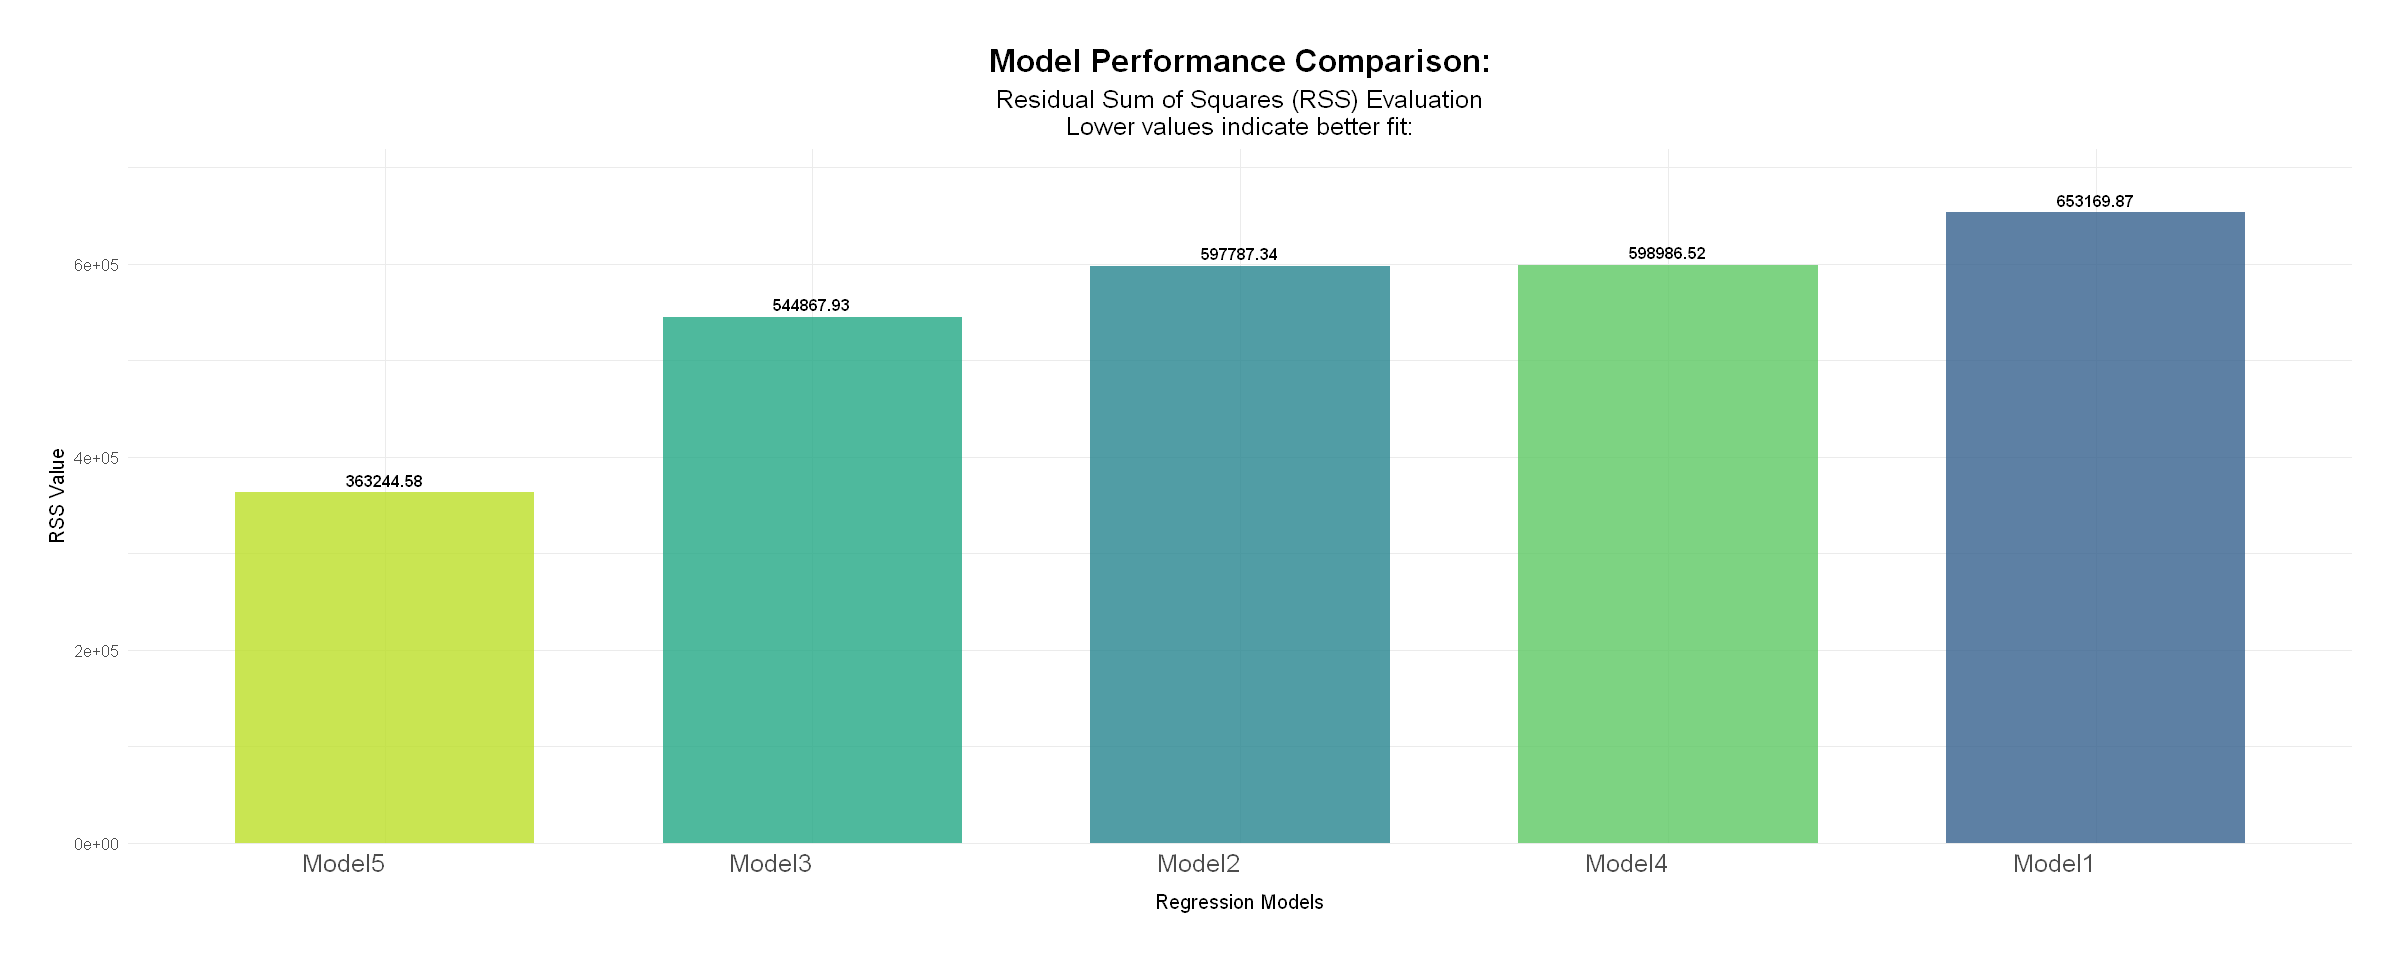

In [33]:
# Plotting the RSS values using bar plots: 

# Prepare data frame for plotting
df <- data.frame(
  Model = names(rss_values),
  RSS = as.numeric(rss_values)
)

# Create bar plot comparing RSS values across models
model_comparison_plot <- ggplot(df, aes(x = reorder(Model, RSS), y = RSS, fill = Model)) +
  
  # Bars and labels
  geom_bar(stat = "identity", width = 0.7, alpha = 0.8) +
  geom_text(aes(label = round(RSS, 2)), vjust = -0.5, size = 3.5, fontface = "bold") +
  
  # Labels and titles
  labs(
    title = "Model Performance Comparison:",
    subtitle = "Residual Sum of Squares (RSS) Evaluation\nLower values indicate better fit:",
    x = "Regression Models",
    y = "RSS Value",
  ) +
  
  # Theme and formatting
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    axis.text.x = element_text(angle = 0, hjust = 1, vjust = 1, size =15),
    axis.title.x = element_text(margin = margin(t = 10)),
    legend.position = "none",
    plot.margin = margin(1, 1, 1, 1, unit = "cm")
  ) +
  
  # Y-axis buffer and color scale
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
  scale_fill_viridis_d(option = "D", begin = 0.3, end = 0.9)

# Set plot size using repr
# width and height are in inches
options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width = 20,   # Set default plot width
        repr.plot.height = 8)  # Set default plot height

# Show the plot
model_comparison_plot

### **Task 2.3: Calculate log-likelihood for each model:**

In [34]:
# Calculate log-likelihood for each model

# The log-likelihood function is:
# ln p(D|θ̂) = -n/2 ln(2π) - n/2 ln(σ̂²) - RSS/(2σ̂²)
# Where σ̂² = RSS/(n-1) is the estimated variance

calculate_log_likelihood <- function(rss, n) {
  # Calculate the estimated variance (σ̂²)
  sigma_squared <- rss / (n - 1)
  
  # Calculate the log-likelihood using the formula
  log_likelihood <- -n/2 * log(2*pi) - n/2 * log(sigma_squared) - rss/(2*sigma_squared)
  
  return(log_likelihood)
}

In [35]:
# Get the number of observations (n)
n <- nrow(data)
cat("Number of observations:", n, "\n\n")

Number of observations: 9527 



In [36]:
# Calculate log-likelihood for each model
# For each model, we use the RSS calculated earlier

ll1 <- calculate_log_likelihood(rss1, n)
ll2 <- calculate_log_likelihood(rss2, n)
ll3 <- calculate_log_likelihood(rss3, n)
ll4 <- calculate_log_likelihood(rss4, n)
ll5 <- calculate_log_likelihood(rss5, n)

In [37]:
# Print the log-likelihood values: 

cat("Log-likelihood values:\n")
cat("Model 1:", ll1, "\n")
cat("Model 2:", ll2, "\n")
cat("Model 3:", ll3, "\n")
cat("Model 4:", ll4, "\n")
cat("Model 5:", ll5)

Log-likelihood values:
Model 1: -33656.91 
Model 2: -33234.86 
Model 3: -32793.32 
Model 4: -33244.4 
Model 5: -30861.88

In [38]:
# Store log-likelihood values

ll_values <- c(
  Model1 = ll1,
  Model2 = ll2,
  Model3 = ll3,
  Model4 = ll4,
  Model5 = ll5
)

In [39]:
# Create comparison table of RSS and log-likelihoods: 

ll_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RSS = c(rss1, rss2, rss3, rss4, rss5),
  LogLikelihood = c(ll1, ll2, ll3, ll4, ll5)
)

# Print the log-likelihood values with RSS: 
ll_comparison

Model,RSS,LogLikelihood
<chr>,<dbl>,<dbl>
Model 1,653169.9,-33656.91
Model 2,597787.3,-33234.86
Model 3,544867.9,-32793.32
Model 4,598986.5,-33244.40
Model 5,363244.6,-30861.88


###  **Task 2.4: Calculate AIC and BIC for each model:**

In [40]:
# Calculate AIC and BIC for each model:

# AIC = 2k - 2ln p(D|θ̂)
# BIC = k·ln(n) - 2ln p(D|θ̂)
# Where:
# - k is the number of parameters in the model
# - n is the number of observations
# - ln p(D|θ̂) is the log-likelihood function

# First, determine the number of parameters (k) for each model
# k includes all coefficients plus the variance parameter
k1 <- ncol(X1)  # Model 1: bias, x4, x3²
k2 <- ncol(X2)  # Model 2: bias, x4, x3², x5
k3 <- ncol(X3)  # Model 3: x3, x4, x5³ (no bias)
k4 <- ncol(X4)  # Model 4: bias, x4, x3², x5³
k5 <- ncol(X5)  # Model 5: bias, x4, x1², x3²

In [41]:
k1 # k-value for model 1

[1] 3

In [42]:
# Function to calculate AIC and BIC:

calculate_aic_bic <- function(log_likelihood, k, n) {
  # Calculate AIC = 2k - 2ln p(D|θ̂)
  aic <- 2*k - 2*log_likelihood
  
  # Calculate BIC = k·ln(n) - 2ln p(D|θ̂)
  bic <- k*log(n) - 2*log_likelihood
  
  return(list(aic = aic, bic = bic))
}

In [43]:
# Calculate AIC and BIC for each model

aic_bic1 <- calculate_aic_bic(ll1, k1, n)
aic_bic2 <- calculate_aic_bic(ll2, k2, n)
aic_bic3 <- calculate_aic_bic(ll3, k3, n)
aic_bic4 <- calculate_aic_bic(ll4, k4, n)
aic_bic5 <- calculate_aic_bic(ll5, k5, n)

In [44]:
aic_bic1 # An example to see how they look

$aic
[1] 67319.82

$bic
[1] 67341.31

In [45]:
# Create a comparison table with AIC, BIC,
# Log-Likelihood, RSS, number of parameters, and model names:

aic_bic_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  Parameters = c(k1, k2, k3, k4, k5),
  RSS = c(rss1, rss2, rss3, rss4, rss5),
  LogLikelihood = c(ll1, ll2, ll3, ll4, ll5),
  AIC = c(aic_bic1$aic, aic_bic2$aic, aic_bic3$aic, aic_bic4$aic, aic_bic5$aic),
  BIC = c(aic_bic1$bic, aic_bic2$bic, aic_bic3$bic, aic_bic4$bic, aic_bic5$bic)
)

# Print the comparison table: 
cat("Model Comparison Table:\n")
aic_bic_comparison

Model Comparison Table:


Model,Parameters,RSS,LogLikelihood,AIC,BIC
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,3,653169.9,-33656.91,67319.82,67341.31
Model 2,4,597787.3,-33234.86,66477.71,66506.36
Model 3,3,544867.9,-32793.32,65592.64,65614.12
Model 4,4,598986.5,-33244.40,66496.80,66525.45
Model 5,4,363244.6,-30861.88,61731.75,61760.40


In [46]:
# Identify the better performing model according to 
# each criterion:AIC, BIC, RSS and Log-Likelihood

best_rss <- aic_bic_comparison$Model[which.min(aic_bic_comparison$RSS)] # low RSS is better
best_aic <- aic_bic_comparison$Model[which.min(aic_bic_comparison$AIC)] # low AIC is better
best_bic <- aic_bic_comparison$Model[which.min(aic_bic_comparison$BIC)] # low BIC is better

cat("\nBetter performing model according to RSS:", best_rss, "\n")
cat("Better performing model according to AIC:", best_aic, "\n")
cat("Better performing model according to BIC:", best_bic, "\n")


Better performing model according to RSS: Model 5 
Better performing model according to AIC: Model 5 
Better performing model according to BIC: Model 5 


In [47]:
# Store the results for later use
aic_values <- c(
  Model1 = aic_bic1$aic,
  Model2 = aic_bic2$aic,
  Model3 = aic_bic3$aic,
  Model4 = aic_bic4$aic,
  Model5 = aic_bic5$aic
)

In [48]:
bic_values <- c(
  Model1 = aic_bic1$bic,
  Model2 = aic_bic2$bic,
  Model3 = aic_bic3$bic,
  Model4 = aic_bic4$bic,
  Model5 = aic_bic5$bic
)

##### **R-squared($R^2$), Adjusted R-squared ($R^2_{\text{adj}}$), Root mean squared error ($RMSE$) and Mean percentage error ($MPE$):**

R-squared also called the coefficient of determination is the measure of how much of the variance in the actual data is explained by the model. Its values ranges from 0 to 1. If we get the value 0 or close to it then this means the model explains nothing and if we get 1 or close to this value then it indicates a perfect fit. 

  $$R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}$$

  Where:
  * $SS_{\text{res}}$ = sum of squared residuals (errors)
  * $SS_{\text{tot}}$ = total sum of squares (variation in actual data)

In [49]:
# RSS values calculated above:
rss1 
rss2
rss3
rss4
rss5 

[1] 653169.9

[1] 597787.3

[1] 544867.9

[1] 598986.5

[1] 363244.6

In [50]:
# R-squared: Proportion of variance explained by the model
r_squared <- function(y, y_pred) {
  ss_res <- sum((y - y_pred)^2)           # Residual sum of squares
  ss_tot <- sum((y - mean(y))^2)          # Total sum of squares
  1 - ss_res / ss_tot                     # R-squared formula
}

Adjusted R-squared ie. adjusted for number of predictions is similar to r-squared but it panelizes models with too many variables. 
This is suitable to compare different models with different number of predictors. This value increase only when adding a new feature(s) improves the model significantly. 

  $$R^2_{\text{adj}} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)$$

  Where:

  * $n$ = number of observations
  * $p$ = number of predictors (independent variables)

In [51]:
# Adjusted R-squared: Adjusts R^2 for number of predictors (p) and observations (n)
# p = number of predictors (excluding intercept)
adjusted_r_squared <- function(y, y_pred, p) {
  n <- length(y)                          # Number of observations
  r2 <- r_squared(y, y_pred)              # R-squared
  1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Adjusted R-squared formula
}
# actual is the vector of observed values (e.g., test or train y).
# predicted is the vector of predicted values from the model.
# p is the number of predictors (not including the intercept).

Root mean squared error(RMSE) also called average size of the error is the avrage size of the prediction errors. Lower the values, better the model is. One negative side of this is that it is sensitive to large errors because it squares the error terms. 

 $$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 }$$

  Where:

  * $y_i$ = actual value
  * $\hat{y}_i$ = predicted value
  * $n$ = number of data points

In [52]:
# Root Mean Squared Error (RMSE): Average magnitude of prediction error
# Function to calculate Root Mean Squared Error (RMSE)
rmse <- function(y, y_pred) {
  sqrt(mean((y - y_pred)^2))              # RMSE formula
}

Mean percentage error (MPE) also called average % difference tells on average how far off the model is, in percentage terms. Can represent the overprediction (ie. negative) or underprediction (ie. positive). 

  $$MPE = \frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{y_i} \right) \times 100$$

  Where:

  * Positive MPE → model tends to underpredict
  * Negative MPE → model tends to overpredict
  * $y_i \neq 0$ is important to avoid division errors

In [53]:
# Mean Percentage Error (MPE): Average percentage error (can be negative)
# Function to calculate Mean Percentage Error (MPE)
mpe <- function(y, y_pred) {
  mean((y - y_pred) / y) * 100            # MPE formula (in percent)
}

In [54]:
# Function to compute all metrics for a list of models
evaluate_models <- function(y, model_list) {
  results <- data.frame(
    Model = character(),
    R2 = numeric(),
    Adj_R2 = numeric(),
    RMSE = numeric(),
    MPE = numeric(),
    stringsAsFactors = FALSE
  )
  for (i in seq_along(model_list)) {
    model <- model_list[[i]]
    X <- model$X
    theta <- model$theta
    y_pred <- X %*% theta
    p <- ncol(X) - as.integer(colnames(X)[1] == "bias") # exclude intercept if present
    results <- rbind(results, data.frame(
      Model = paste0("Model ", i),
      R2 = r_squared(y, y_pred),
      Adj_R2 = adjusted_r_squared(y, y_pred, p),
      RMSE = rmse(y, y_pred),
      MPE = mpe(y, y_pred)
    ))
  }
  return(results)
}

# Prepare your models as a list
model_list <- list(
  list(X = X1, theta = theta1),
  list(X = X2, theta = theta2),
  list(X = X3, theta = theta3),
  list(X = X4, theta = theta4),
  list(X = X5, theta = theta5)
)

# Call the function and print the summary table
metrics_summary <- evaluate_models(y, model_list)
print(metrics_summary)

    Model        R2    Adj_R2     RMSE         MPE
1 Model 1 0.7638308 0.7637812 8.280089 -0.03205152
2 Model 2 0.7838557 0.7837876 7.921278 -0.02926641
3 Model 3 0.8029900 0.8029279 7.562537 -0.02758429
4 Model 4 0.7834221 0.7833539 7.929219 -0.02933618
5 Model 5 0.8686602 0.8686189 6.174780 -0.01748955


### **Task 2.5: Analyzing Residual Distributions:**

**Understanding Residuals and Their Importance:**

> $Residuals$ = $Actual$ $values$ - $Predicted$ $values$
 
Residuals are the differences between observed values and model predictions. In regression analysis, we assume these residuals follow a normal distribution with mean zero. This assumption is crucial because:


- It validates the statistical tests used in regression

- It confirms that our model captures the systematic patterns in the data

- It ensures prediction intervals are accurate

- It indicates whether our model form is appropriate

Let's first calculate and extract the residuals for each model:

In [55]:
# Analysis of the Distribution of Residuals:

# This analysis helps verify if model assumptions are met, particularly:
# - Normality of residuals (should follow a normal distribution)
# - Homoscedasticity (constant variance across predictions)
# - Independence (no patterns in residuals)

# Calculate residuals for each model: 
# Residuals = Actual values - Predicted values
residuals1 <- y - X1 %*% theta1
residuals2 <- y - X2 %*% theta2
residuals3 <- y - X3 %*% theta3
residuals4 <- y - X4 %*% theta4
residuals5 <- y - X5 %*% theta5

# Store residuals in a data frame for easier analysis
residuals_df <- data.frame(
  Model1 = as.vector(residuals1),
  Model2 = as.vector(residuals2),
  Model3 = as.vector(residuals3),
  Model4 = as.vector(residuals4),
  Model5 = as.vector(residuals5)
)

# Preview the first few residuals
cat("First few residuals for each model:\n")
head(residuals_df)

First few residuals for each model:


,Model1,Model2,Model3,Model4,Model5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.9743117,11.9419312,10.688250,11.6988955,7.801083
2,-4.6471297,-4.9506270,-3.092226,-4.4408626,-2.766587
3,-10.9843480,-5.5243992,-6.209697,-6.9135290,2.384140
4,-3.8678454,-4.0191281,-3.054242,-3.5023381,-5.102528
5,-5.6603746,-9.0207110,-10.511198,-10.1419722,-7.143245
6,0.3530112,-0.7387404,-1.819439,-0.6145755,1.226023


In [56]:
dim(residuals_df)

[1] 9527    5

In [57]:
# Calculate basic statistics for residuals:

# Function to calculate residual statistics: 
get_residual_stats <- function(residuals) {
  data.frame(
    Mean = mean(residuals),                # this should be close to zero
    Median = median(residuals),            # this should be close to zero
    SD = sd(residuals),                    # this is the measure of spread
    Skewness = skewness(residuals),        # this should be close to 0 for normal distribution
    Kurtosis = kurtosis(residuals),        # this should be close to 3 for normal distribution
    Min = min(residuals),                  # the minimum residual for the model 
    Max = max(residuals),                  # maximum residual for model
    Range = max(residuals) - min(residuals) # range of residuals: (max - min)
  )
}

In [58]:
# Calculate statistics for each model: 

stats1 <- get_residual_stats(residuals1)
stats2 <- get_residual_stats(residuals2)
stats3 <- get_residual_stats(residuals3)
stats4 <- get_residual_stats(residuals4)
stats5 <- get_residual_stats(residuals5)

In [59]:
# Combine all statistics into a single table for better comparision: 

residual_stats <- rbind(stats1, stats2, stats3, stats4, stats5)
rownames(residual_stats) <- c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5")

# Print the statistics: 
cat("\nResidual Statistics:\n")
residual_stats


Residual Statistics:


,Mean,Median,SD,Skewness,Kurtosis,Min,Max,Range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,3.514445e-09,-0.4406750,8.280523,0.2127529,3.368935,-34.94980,35.67531,70.62511
Model 2,2.634844e-09,-0.2588325,7.921694,0.2526849,3.423191,-37.14753,32.20697,69.35451
Model 3,-1.936052e-03,-0.1383793,7.562934,0.1894891,3.605181,-38.49677,32.78064,71.27741
Model 4,1.402345e-09,-0.2989428,7.929636,0.2567837,3.421695,-38.24911,32.17039,70.41950
Model 5,3.624688e-09,-0.5632009,6.175104,0.2992942,3.589626,-38.92361,22.00756,60.93117


#### **Normality Tests for the Distribution of Residuals:**

**Histograms with Density + Rug plts:**

No id variables; using all as measure variables



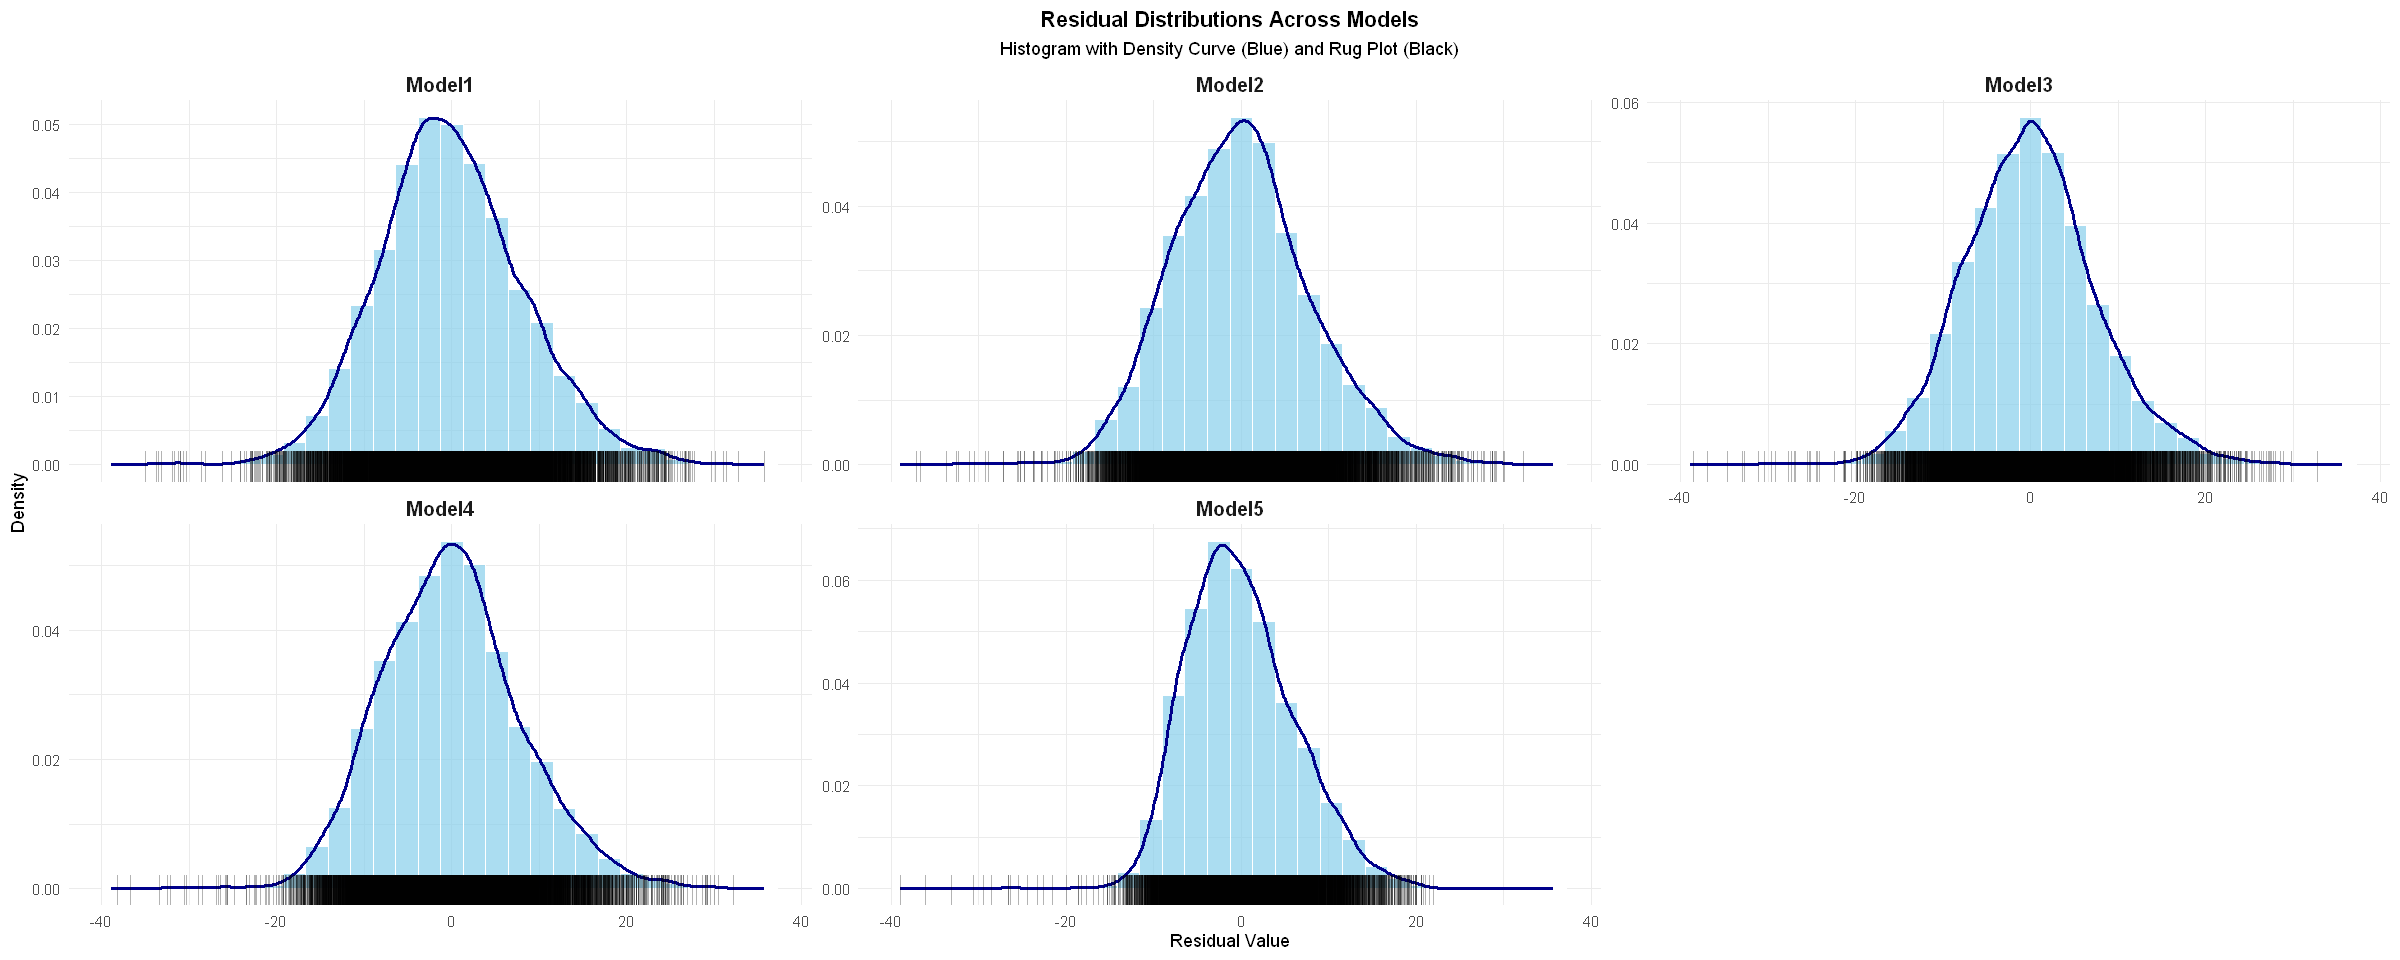

In [60]:
# hide warnings;
options(warn = -1)

# Load necessary libraries
library(ggplot2)
library(reshape2)

# Convert wide-format residuals data frame to long-format for ggplot
# This makes plotting multiple models easier using 'facet_wrap'
residuals_long <- melt(
  residuals_df,
  variable.name = "Model",    # Name for the column containing model names
  value.name = "Residual"     # Name for the column containing residuals
)

# Create histogram plot with density overlay and rug plot for each model
hist_plot <- ggplot(residuals_long, aes(x = Residual)) +
  
  # Plot histogram of residuals with density scaling
  geom_histogram(
    aes(y = ..density..),     # Use density instead of raw counts
    bins = 30,                # Number of bins in histogram
    fill = "skyblue",         # Bar fill color
    color = "white",          # Border color of bars
    alpha = 0.7               # Transparency for visual softness
  ) +
  
  # Add actual density curve (smooth estimate of distribution)
  geom_density(
    color = "darkblue",       # Line color for density
    linewidth = 1             # Line thickness
  ) +
  
  # Add rug plot for residuals (shows individual values)
  geom_rug(
    aes(x = Residual), 
    sides = "b", 
    color = "black", 
    alpha = 0.3, 
    length = unit(0.08, "npc")
  ) +
  
  # Facet the plot by each model so each gets its own histogram
  facet_wrap(~ Model, scales = "free_y") +
  
  # Add informative titles and axis labels
  labs(
    title = "Residual Distributions Across Models",
    subtitle = "Histogram with Density Curve (Blue) and Rug Plot (Black)",
    x = "Residual Value",
    y = "Density"
  ) +
  
  # Use a clean minimal theme for clarity
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),     # Model names
    plot.title = element_text(hjust = 0.5, face = "bold"),   # Centered bold title
    plot.subtitle = element_text(hjust = 0.5)                # Centered subtitle
  )

# Show the plot
print(hist_plot)
# Reset warnings settings:
options(warn = 0)

**QQ-Plots for Normality Check:** 

Q-Q plot (Quantile-Quantile plot) compares the quantiles of the residuals (sample quantiles) to the quantiles of a theoretical distribution (commonly the standard normal distribution). If the residuals are normally distributed, the points should fall approximately along a straight 45-degree reference line. Deviation from this line, especially in the tails, suggests non-normality.

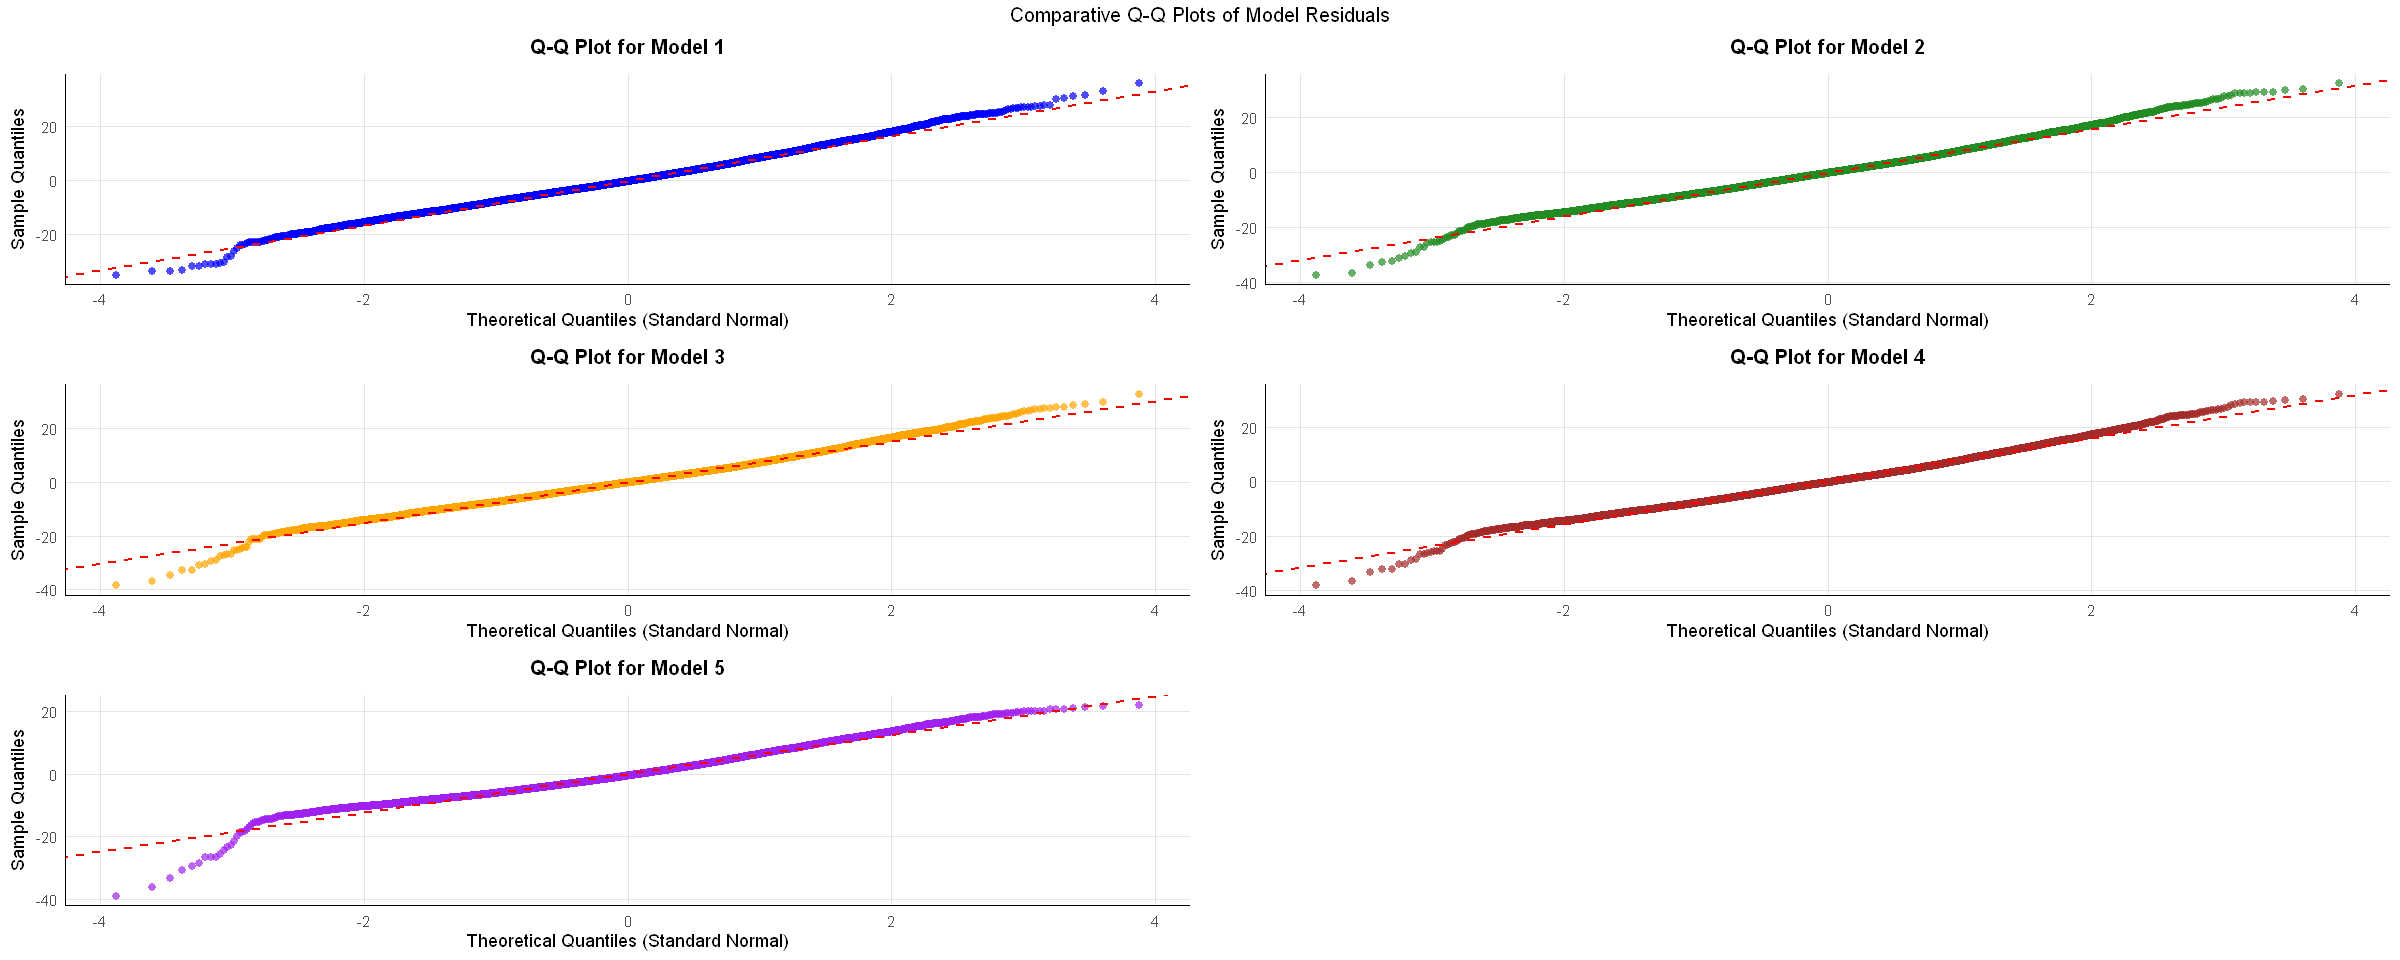

In [61]:
# Load required libraries
library(ggplot2)      # For creating the Q-Q plot
library(gridExtra)    # For arranging multiple plots (if needed)

#' Create a Quantile-Quantile (Q-Q) Plot Residuals
#' 
#'Creates a Q-Q plot against the standard normal distribution.
#'
#' @param residuals Numeric vector of model residuals (must be clean)
#' @param model_name Character string for plot title (default: "Model")
#' @param point_color Color for Q-Q points (default: "steelblue")
#' @param point_alpha Transparency for points (default: 0.7)
#' @param point_size Size of points (default: 2)
#' @param line_color Color for reference line (default: "red")
#' @param line_type Linetype for reference line (default: "dashed")
#' @param line_width Width of reference line (default: 0.8)
#' 
#' @return A ggplot object containing the Q-Q plot
create_qq_plot <- function(residuals, 
                                model_name = "Model", 
                                point_color = "steelblue",
                                point_alpha = 0.7,
                                point_size = 2,
                                line_color = "red",
                                line_type = "dashed",
                                line_width = 0.8) {

  # Calculate Theoretical and Sample Quantiles
  # Get number of observations
  n <- length(residuals)
  
  # Calculate probability points using Blom's method
  # (1:n - 0.5)/n gives unbiased quantile estimates for normal distribution
  p <- (1:n - 0.5) / n
  
  # Get theoretical quantiles from standard normal distribution
  theoretical_q <- qnorm(p)
  
  # Get empirical quantiles by sorting the residuals
  empirical_q <- sort(residuals)
  
  # Prepare Data for Plotting

  # Create data frame for ggplot
  qq_data <- data.frame(
    Theoretical = theoretical_q,  # x-axis values
    Empirical = empirical_q       # y-axis values
  )
  
  # Calculate parameters for reference line
  # Using mean and sd of residuals makes the line represent
  # what we would expect if residuals were perfectly normal
  ref_intercept <- mean(residuals)
  ref_slope <- sd(residuals)
  
  # Create the Q-Q Plot: 
  
  # Initialize ggplot with our data
  qq_plot <- ggplot(qq_data, aes(x = Theoretical, y = Empirical)) +
    
    # Add the points for the Q-Q plot
    geom_point(
      color = point_color,      # Point color from parameters
      alpha = point_alpha,      # Transparency from parameters
      size = point_size,        # Size from parameters
      shape = 16                # Solid circle shape (16 is ggplot's default)
    ) +
    
    # Add the reference line
    # This line shows what perfect normality would look like
    geom_abline(
      intercept = ref_intercept,  # Line intercept (mean of residuals)
      slope = ref_slope,          # Line slope (sd of residuals)
      color = line_color,         # Line color from parameters
      linetype = line_type,       # Line type from parameters
      linewidth = line_width      # Line width from parameters
    ) +
    
    # Add labels and title
    labs(
      title = paste("Q-Q Plot for", model_name),  # Dynamic title with model name
      x = "Theoretical Quantiles (Standard Normal)",  # x-axis label
      y = "Sample Quantiles"                     # y-axis label
    ) +
    
    # Apply minimal theme (clean background)
    theme_minimal() +
    
    # Customize theme elements
    theme(
      plot.title = element_text(
        hjust = 0.5,            # Center the title
        face = "bold",          # Bold font
        size = 12,             # Slightly larger size
        margin = margin(b = 10) # Add space below title
      ),
      panel.grid.minor = element_blank(),  # Remove minor grid lines
      panel.grid.major = element_line(color = "grey90"),  # Light grid lines
      axis.line = element_line(color = "black")  # Add axis lines
    )
  
  # Return the plot object
  return(qq_plot)
}
# Example usage (assuming residuals1-residuals5 exist):
qq1 <- create_qq_plot(residuals1, "Model 1", point_color= "blue")
qq2 <- create_qq_plot(residuals2, "Model 2", point_color= "forestgreen")
qq3 <- create_qq_plot(residuals3, "Model 3", point_color="orange" )
qq4 <- create_qq_plot(residuals4, "Model 4", point_color= "brown")
qq5 <- create_qq_plot(residuals5, "Model 5", point_color= "purple")

# Arrange plots with proper layout
combined_qq <- grid.arrange(
   qq1, qq2, qq3, qq4, qq5,
   ncol = 2,
   top = "Comparative Q-Q Plots of Model Residuals"
 )

We want to compare each model’s residuals against the standard normal distribution (mean 0, sd 1), so first we standardize the residuals for each model.

In [62]:
residuals1_std <- scale(residuals1)
residuals2_std <- scale(residuals2)
residuals3_std <- scale(residuals3)
residuals4_std <- scale(residuals4)
residuals5_std <- scale(residuals5)

Now, plot the qq-plots for the standardized residuals of all the models:

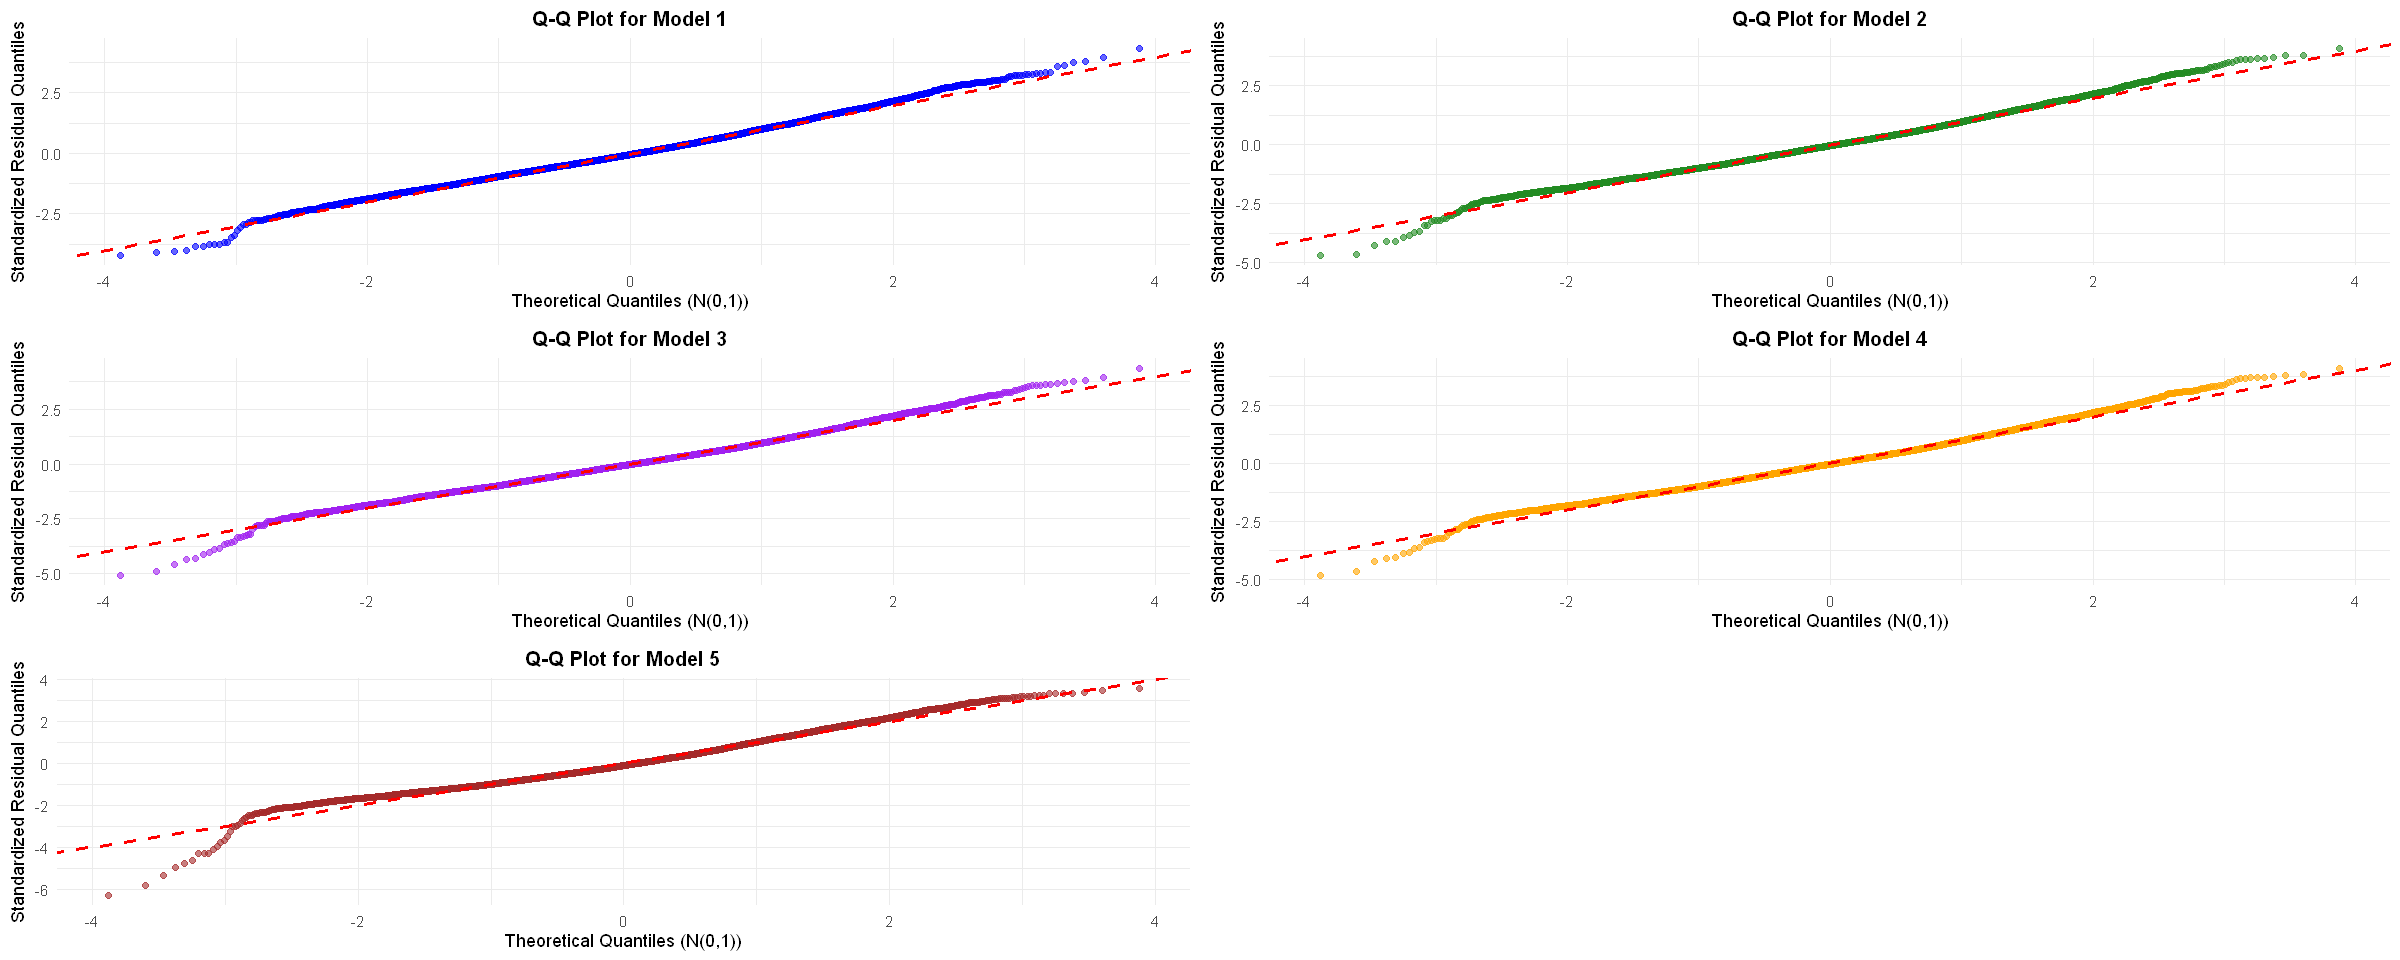

In [63]:
# Load required libraries
library(ggplot2)    # For creating plots
library(gridExtra)  # For arranging multiple plots in a grid

# Function to create a Q-Q plot for standardized residuals
create_qq_plot <- function(residuals_std, model_name, point_color) {

  # Get the number of residuals
  n <- length(residuals_std)

  # Compute the percentiles for the residuals
  # These are used to get the corresponding theoretical quantiles
  p <- (1:n - 0.5) / n

  # Compute the theoretical quantiles from the standard normal distribution
  theoretical_q <- qnorm(p)

  # Sort the standardized residuals to get empirical quantiles
  empirical_q <- sort(residuals_std)

  # Create a data frame with both quantiles for plotting
  qq_data <- data.frame(
    Theoretical = theoretical_q,
    Empirical = empirical_q
  )

  # Create the Q-Q plot
  ggplot(qq_data, aes(x = Theoretical, y = Empirical)) +
    geom_point(color = point_color, alpha = 0.6) +  # Add the points (empirical vs theoretical)
    
    # Add a 45-degree reference line (y = x), indicating perfect normality
    geom_abline(intercept = 0, slope = 1, color = "red", 
                linetype = "dashed", linewidth = 1) +

    # Add titles and axis labels
    labs(
      title = paste("Q-Q Plot for", model_name),
      x = "Theoretical Quantiles (N(0,1))",
      y = "Standardized Residual Quantiles"
    ) +

    # Use a minimal theme for a clean look
    theme_minimal() +

    # Customize the plot title appearance
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 12)
    )
}

# Create Q-Q plots for each model using their standardized residuals and a unique color
qq1 <- create_qq_plot(residuals1_std, "Model 1", "blue")
qq2 <- create_qq_plot(residuals2_std, "Model 2", "forestgreen")
qq3 <- create_qq_plot(residuals3_std, "Model 3", "purple")
qq4 <- create_qq_plot(residuals4_std, "Model 4", "orange")
qq5 <- create_qq_plot(residuals5_std, "Model 5", "brown")

# Display all five plots in a 2-column grid layout
# This helps visually compare the residual normality across models
grid.arrange(qq1, qq2, qq3, qq4, qq5, ncol = 2)

##### **Proportion of Residuals within different Standard Deviation Ranges:**

In [64]:
# Calculate proportion of residuals within different standard deviation ranges

# For a normal distribution:
# - ~68% of values should be within 1 standard deviation of the mean
# - ~95% of values should be within 2 standard deviations
# - ~99.7% of values should be within 3 standard deviations

# Function to calculate normality measures
calculate_normality_measures <- function(residuals, model_name) {
  # Calculate basic statistics
  mean_val <- mean(residuals)
  median_val <- median(residuals)
  sd_val <- sd(residuals)
  
  # Calculate standardized residuals
  std_residuals <- (residuals - mean_val) / sd_val
  
  # Calculate proportion within different SD ranges
  within_1sd <- mean(abs(std_residuals) <= 1) * 100
  within_2sd <- mean(abs(std_residuals) <= 2) * 100
  within_3sd <- mean(abs(std_residuals) <= 3) * 100
  
  # Expected proportions for normal distribution
  expected_1sd <- 68.27
  expected_2sd <- 95.45
  expected_3sd <- 99.73
  
  # Create results data frame
  data.frame(
    Model = model_name,
    Within1SD = sprintf("%.2f%% (Exp: 68.27%%)", within_1sd),
    Within2SD = sprintf("%.2f%% (Exp: 95.45%%)", within_2sd),
    Within3SD = sprintf("%.2f%% (Exp: 99.73%%)", within_3sd),
    Skewness = round(skewness(residuals), 4),
    ExcessKurtosis = round(kurtosis(residuals) - 3, 4)
  )
}

# Calculate measures for each model
measures1 <- calculate_normality_measures(residuals1, "Model 1")
measures2 <- calculate_normality_measures(residuals2, "Model 2")
measures3 <- calculate_normality_measures(residuals3, "Model 3")
measures4 <- calculate_normality_measures(residuals4, "Model 4")
measures5 <- calculate_normality_measures(residuals5, "Model 5")

# Combine results
normality_measures <- rbind(measures1, measures2, measures3, measures4, measures5)

# Print results
cat("\nNormality Distribution Measures:\n")
normality_measures


Normality Distribution Measures:


Model,Within1SD,Within2SD,Within3SD,Skewness,ExcessKurtosis
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Model 1,69.33% (Exp: 68.27%),95.37% (Exp: 95.45%),99.58% (Exp: 99.73%),0.2128,0.3689
Model 2,69.17% (Exp: 68.27%),95.69% (Exp: 95.45%),99.37% (Exp: 99.73%),0.2527,0.4232
Model 3,69.62% (Exp: 68.27%),95.07% (Exp: 95.45%),99.40% (Exp: 99.73%),0.1895,0.6052
Model 4,68.94% (Exp: 68.27%),95.63% (Exp: 95.45%),99.35% (Exp: 99.73%),0.2568,0.4217
Model 5,68.23% (Exp: 68.27%),95.85% (Exp: 95.45%),99.51% (Exp: 99.73%),0.2993,0.5896


##### **Residuals vs. Fitted Values:**

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


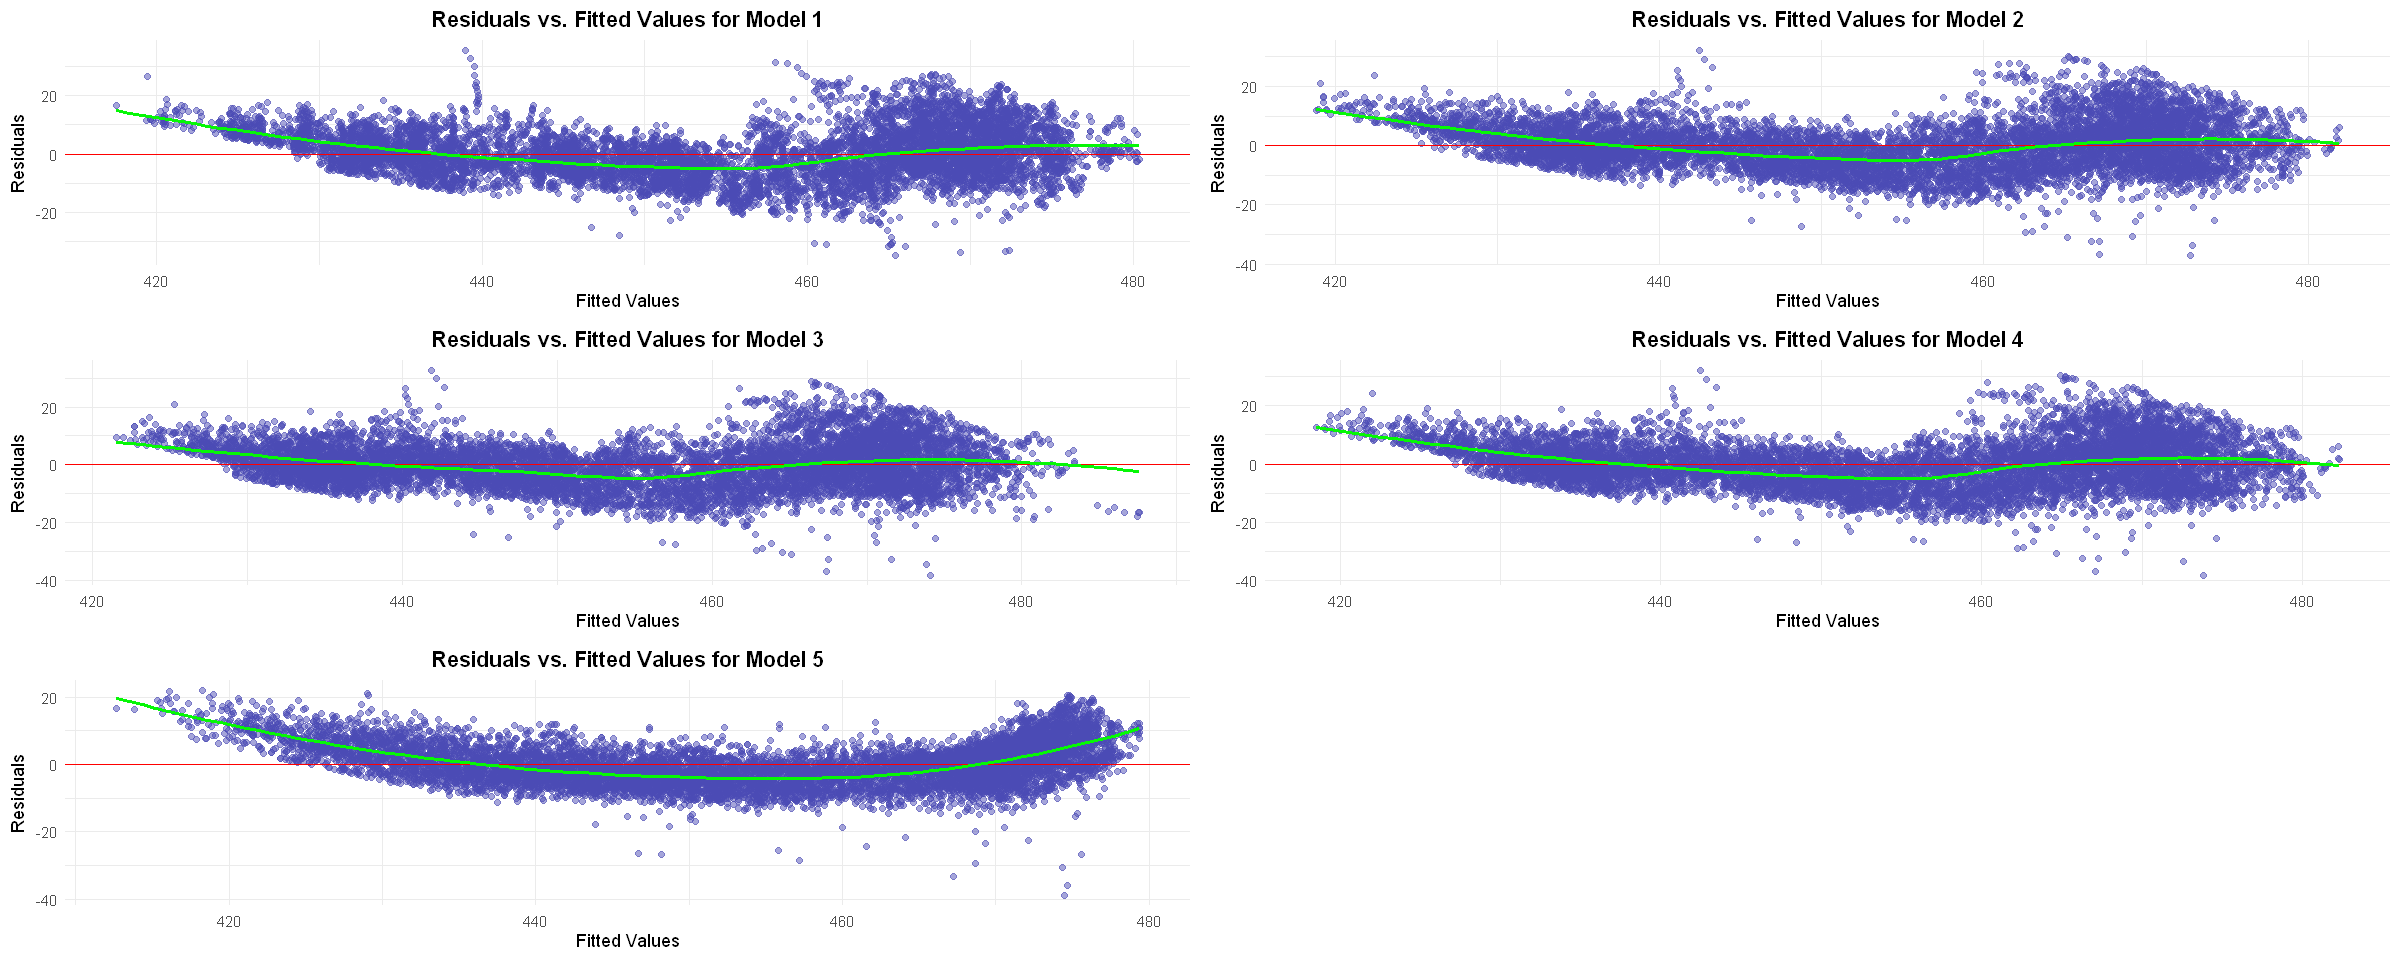

In [65]:
# Create residual plots (residuals vs. fitted values):

# These plots help check for homoscedasticity and patterns in residuals

# Function to create residual vs. fitted plot: 
create_residual_plot <- function(X, theta, residuals, model_name) {
  # Calculate fitted values
  fitted_values <- X %*% theta
  
  # Create data frame for plotting
  plot_data <- data.frame(
    Fitted = as.vector(fitted_values),
    Residual = as.vector(residuals)
  )
  
  # Create the plot
  ggplot(plot_data, aes(x = Fitted, y = Residual)) +
    geom_point(alpha = 0.5, color = "#4b4bb5") +
    geom_hline(yintercept = 0, linetype = "solid", color = "red") +
    geom_smooth(method = "loess", se = FALSE, color = "#06f706") +
    labs(title = paste("Residuals vs. Fitted Values for", model_name),
         x = "Fitted Values",
         y = "Residuals") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5)
    )
}

# Create residual plots for each model
res_plot1 <- create_residual_plot(X1, theta1, residuals_df$Model1, "Model 1")
res_plot2 <- create_residual_plot(X2, theta2, residuals_df$Model2, "Model 2")
res_plot3 <- create_residual_plot(X3, theta3, residuals_df$Model3, "Model 3")
res_plot4 <- create_residual_plot(X4, theta4, residuals_df$Model4, "Model 4")
res_plot5 <- create_residual_plot(X5, theta5, residuals_df$Model5, "Model 5")

# Display the residual plots
grid.arrange(res_plot1, res_plot2, res_plot3, res_plot4, res_plot5, ncol = 2)

#### **Task 2.6: Selecting the Best Regression Model:**

In [66]:
# we have some metrics from regression metrics: R², Adjusted R², RMSE, MPE :  
(metrics_summary)

Model,R2,Adj_R2,RMSE,MPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,0.7638308,0.7637812,8.280089,-0.03205152
Model 2,0.7838557,0.7837876,7.921278,-0.02926641
Model 3,0.8029900,0.8029279,7.562537,-0.02758429
Model 4,0.7834221,0.7833539,7.929219,-0.02933618
Model 5,0.8686602,0.8686189,6.174780,-0.01748955


Now, finally we can create a model selection table based on all the statistics and computations we have like: `rss`, `ll`, `aic`, `bic`, `R2`, `Adj_R2`, `RMSE`, `MPE`, `residual_stats`, `normality_measures`, etc. 

In [67]:
# Create the comparison table for comparision: 
comparison_table <- data.frame(
  Model_1 = c(
    round(rss_comparison$RSS[1], 2),
    round(ll_comparison$LogLikelihood[1], 2),
    round(aic_bic_comparison$AIC[1], 2),
    round(aic_bic_comparison$BIC[1], 2),
    round(metrics_summary$R2[1], 2),
    round(metrics_summary$Adj_R2[1], 2),
    round(metrics_summary$RMSE[1], 2),
    round(metrics_summary$MPE[1], 2), 
    round(residual_stats$Mean[1], 6),
    round(residual_stats$Median[1], 2),
    round(residual_stats$SD[1], 2),
    round(residual_stats$Skewness[1], 3),
    round(residual_stats$Kurtosis[1], 3),
    round(residual_stats$Min[1], 2),
    round(residual_stats$Max[1], 2),
    round(residual_stats$Range[1], 2),
    normality_measures$Within1SD[1],
    normality_measures$Within2SD[1],
    normality_measures$Within3SD[1],
    round(normality_measures$ExcessKurtosis[1], 3)
  ),
  Model_2 = c(
    round(rss_comparison$RSS[2], 2),
    round(ll_comparison$LogLikelihood[2], 2),
    round(aic_bic_comparison$AIC[2], 2),
    round(aic_bic_comparison$BIC[2], 2),
    round(metrics_summary$R2[2], 2),
    round(metrics_summary$Adj_R2[2], 2),
    round(metrics_summary$RMSE[2], 2),
    round(metrics_summary$MPE[2], 2),
    round(residual_stats$Mean[2], 6),
    round(residual_stats$Median[2], 2),
    round(residual_stats$SD[2], 2),
    round(residual_stats$Skewness[2], 3),
    round(residual_stats$Kurtosis[2], 3),
    round(residual_stats$Min[2], 2),
    round(residual_stats$Max[2], 2),
    round(residual_stats$Range[2], 2),
    normality_measures$Within1SD[2],
    normality_measures$Within2SD[2],
    normality_measures$Within3SD[2],
    round(normality_measures$ExcessKurtosis[2], 3)
  ),
  Model_3 = c(
    round(rss_comparison$RSS[3], 2),
    round(ll_comparison$LogLikelihood[3], 2),
    round(aic_bic_comparison$AIC[3], 2),
    round(aic_bic_comparison$BIC[3], 2),
    round(metrics_summary$R2[3], 2),
    round(metrics_summary$Adj_R2[3], 2),
    round(metrics_summary$RMSE[3], 2),
    round(metrics_summary$MPE[3], 2), 
    round(residual_stats$Mean[3], 2),
    round(residual_stats$Median[3], 2),
    round(residual_stats$SD[3], 2),
    round(residual_stats$Skewness[3], 3),
    round(residual_stats$Kurtosis[3], 3),
    round(residual_stats$Min[3], 2),
    round(residual_stats$Max[3], 2),
    round(residual_stats$Range[3], 2),
    normality_measures$Within1SD[3],
    normality_measures$Within2SD[3],
    normality_measures$Within3SD[3],
    round(normality_measures$ExcessKurtosis[3], 3)
  ),
  Model_4 = c(
    round(rss_comparison$RSS[4], 2),
    round(ll_comparison$LogLikelihood[4], 2),
    round(aic_bic_comparison$AIC[4], 2),
    round(aic_bic_comparison$BIC[4], 2),
    round(metrics_summary$R2[4], 2),
    round(metrics_summary$Adj_R2[4], 2),
    round(metrics_summary$RMSE[4], 2),
    round(metrics_summary$MPE[4], 2), 
    round(residual_stats$Mean[4], 6),
    round(residual_stats$Median[4], 2),
    round(residual_stats$SD[4], 2),
    round(residual_stats$Skewness[4], 3),
    round(residual_stats$Kurtosis[4], 3),
    round(residual_stats$Min[4], 2),
    round(residual_stats$Max[4], 2),
    round(residual_stats$Range[4], 2),
    normality_measures$Within1SD[4],
    normality_measures$Within2SD[4],
    normality_measures$Within3SD[4],
    round(normality_measures$ExcessKurtosis[4], 3)
  ),
  Model_5 = c(
    round(rss_comparison$RSS[5], 2),
    round(ll_comparison$LogLikelihood[5], 2),
    round(aic_bic_comparison$AIC[5], 2),
    round(aic_bic_comparison$BIC[5], 2),
    round(metrics_summary$R2[5], 2),
    round(metrics_summary$Adj_R2[5], 2),
    round(metrics_summary$RMSE[5], 2),
    round(metrics_summary$MPE[5], 2), 
    round(residual_stats$Mean[5], 6),
    round(residual_stats$Median[5], 2),
    round(residual_stats$SD[5], 2),
    round(residual_stats$Skewness[5], 3),
    round(residual_stats$Kurtosis[5], 3),
    round(residual_stats$Min[5], 2),
    round(residual_stats$Max[5], 2),
    round(residual_stats$Range[5], 2),
    normality_measures$Within1SD[5],
    normality_measures$Within2SD[5],
    normality_measures$Within3SD[5],
    round(normality_measures$ExcessKurtosis[5], 3)
  ),
  row.names = c(
    "RSS", 
    "Log-Likelihood", 
    "AIC", 
    "BIC", 
    "R2",
    "Adj_R2",
    "RMSE",
    "MPE",
    "Residual_Mean", 
    "Residual_Median", 
    "Residual_SD", 
    "Residual_Skewness", 
    "Residual_Kurtosis", 
    "Residual_Min", 
    "Residual_Max", 
    "Residual_Range", 
    "Residuals_Within1SD", 
    "Residuals_Within2SD", 
    "Residuals_Within3SD", 
    "Residuals_ExcessKurtosis"
  )
)

# Print the comparison table
comparison_table

,Model_1,Model_2,Model_3,Model_4,Model_5
,<chr>,<chr>,<chr>,<chr>,<chr>
RSS,653169.87,597787.34,544867.93,598986.52,363244.58
Log-Likelihood,-33656.91,-33234.86,-32793.32,-33244.4,-30861.88
AIC,67319.82,66477.71,65592.64,66496.8,61731.75
BIC,67341.31,66506.36,65614.12,66525.45,61760.4
R2,0.76,0.78,0.8,0.78,0.87
Adj_R2,0.76,0.78,0.8,0.78,0.87
RMSE,8.28,7.92,7.56,7.93,6.17
MPE,-0.03,-0.03,-0.03,-0.03,-0.02
Residual_Mean,0,0,0,0,0


To make this Table even more visually appealing, we can do formatting using `kable` from the `knitr`:

In [68]:
# Create a formatted version with kable for better display:
library(knitr)
kable(comparison_table, 
      caption = "Models Comparison Table Based on all Calculated Metrics:",
      align = c('c', 'c', 'c', 'c', 'c', 'c'))

# Add model formulas for reference
model_formulas <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  Formula = c(
    "y = θ₁x₄ + θ₂x₃² + θ_bias",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias",
    "y = θ₁x₃ + θ₂x₄ + θ₃x₅³",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias",
    "y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias"
  )
)
# Print model formulas
kable(model_formulas, caption = "Formulas for each Model:")



Table: Models Comparison Table Based on all Calculated Metrics:

|                         |       Model_1        |       Model_2        |       Model_3        |       Model_4        |       Model_5        |
|:------------------------|:--------------------:|:--------------------:|:--------------------:|:--------------------:|:--------------------:|
|RSS                      |      653169.87       |      597787.34       |      544867.93       |      598986.52       |      363244.58       |
|Log-Likelihood           |      -33656.91       |      -33234.86       |      -32793.32       |       -33244.4       |      -30861.88       |
|AIC                      |       67319.82       |       66477.71       |       65592.64       |       66496.8        |       61731.75       |
|BIC                      |       67341.31       |       66506.36       |       65614.12       |       66525.45       |       61760.4        |
|R2                       |         0.76         |         0.78         |  



Table: Formulas for each Model:

|Model   |Formula                           |
|:-------|:---------------------------------|
|Model 1 |y = θ₁x₄ + θ₂x₃² + θ_bias         |
|Model 2 |y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias  |
|Model 3 |y = θ₁x₃ + θ₂x₄ + θ₃x₅³           |
|Model 4 |y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias |
|Model 5 |y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias |

In [77]:
# Make predictions for model 5: 
 y_pred5 <- X5 %*% theta5
 head(y_pred5)

472.6789
448.5166
436.3759
458.1925
471.5732
469.7340
